<center><h1>A stochastic model of stem cell proliferation, based on the growth of spleen colony-forming cells</h1><br>
<h2>Reading Course 2015</h2>
<h2>Session 2</h2>
<h2>Michael Strasser</h2><br>
<h3>29/04/2015</h3><br>
<h3>Institute of Computational Biology, Helmholtz Zentrum Muenchen</h3><br>

<br>
</center>

In [7]:
import  scipy.stats as stats
from scipy.stats import binom
from __future__ import division

In [8]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


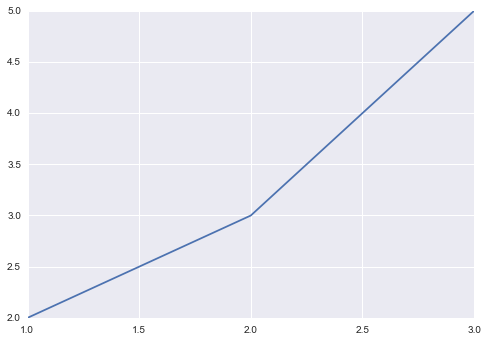

In [9]:
import seaborn as sns
plt.plot([1,2,3], [2,3,5])
pylab.rcParams['figure.figsize'] = 12, 6

## Hematopoiesis
- best studied stem cell system
- easy access
- clean (celltypes are known)

### Current view
![Orkin2](figures/Orkin2.png)
Orkin, S. H. & Zon, L. I. Hematopoiesis: an evolving paradigm for stem cell biology. Cell 132, 631–44 (2008).

![Orkin1](figures/Orkin1.png)
Orkin, S. H. & Zon, L. I. Hematopoiesis: an evolving paradigm for stem cell biology. Cell 132, 631–44 (2008).

### Hematopoiesis in 1960
![Fig2Model](figures/Fig2Model.png)

##About the paper
> Till, J. E., McCulloch, E. a. & Siminovitch, L. A stochastic model of stem cell proliferation, based on the growth of spleen colony-forming cells . Proc. Natl. Acad. Sci. U. S. A. 51, 29–36 (1964).

- First evidence for **stem cells** by Till/McCulloch around 1960
> The Radiation Sensitivity of Normal Mouse Bone Marrow Cells, Determined by Quantitative Marrow Transplantation into Irradiated Mice

- This one is a follow up, analysing data from 
> Siminovitch, L., McCulloch, E. & Till, J. The distribution of colony forming cells among spleen colonies'

##Evidence for stem cells
- Inject bone marrow cells into irradiated mice
![setupFig](figures/Fig2Setup.png)
- Marrow cells form colonies in spleen (german: 'Milz', part of blood/lymph-system):

  **Colony forming cells/units (CFU)**
![spleenFig](figures/Fig3Spleen.png)

## Analysis of the colonies/CFUs
- Rare celltype: 1/10000 cells![](figures/rareCelltype.png)
- Colonies contain different kinds of blood cells
  - **multipotent**
- Colonies contain CFUs again (secondary transplants)
  - **self renewal**
- Capable of rapid proliferation: $10^6$ cell progeny in 10 days
- What's the number of divisions and the division time?


In [10]:
nCells = 1e6
nDays  = 10
nDivisions = np.log2(nCells)
time_per_division = nDays * 24 / nDivisions
print "#Generations/Divisions: %d\n\nAverage generation time %.2f (hours)" %(round(nDivisions), time_per_division)

#Generations/Divisions: 20

Average generation time 12.04 (hours)


## Defining properties of stem cells   
- **multipotent** and able to **differentiate** 
    - visual inspection of spleen colonies
    - spleen colonies contain diff. cells
<p>
<p>
- are capable of **self-renewal** 
    - secondary "transplants"
    - cells within the spleen colonies still have stem cell props
     

<h2>BASIC DEFINITION OF STEM CELLS EVEN TODAY</h2>

# Basic Questions
- how is this balance between self-renewal and differentation regulated
- Theories
     - **deterministic** : tighly controlled, each cell knows what to do
     - **stochastic**: no control, seemingly random

# The data
> The distribution of colony forming cells among spleen colonies, Siminovitch 1963

- Table 2,3 of Siminovitch
- Number of CFU per colony (i.e. #stem cells per colony)

<img src="figures/ExperimentData.png" alt="Drawing" style="width: 600px;"/>

In [11]:
colonies_per_spleen = dict()
colonies_per_spleen["exp1"] = np.concatenate([np.repeat(0,24),
                                      np.repeat(1,6),
                                      np.array([2,6,19,21,23,36])
                                      ])

colonies_per_spleen["exp2"] = np.concatenate([np.repeat(0,3),
                                      np.repeat(1,3),
                                      np.repeat(2,2),
                                      np.array([3,3, 20,20, 32])
                                      ])

colonies_per_spleen["exp3"]= np.concatenate([np.repeat(0,12),
                                      np.repeat(1,8),
                                      np.repeat(2,5),
                                      np.repeat(3,2),
                                      np.array([4,5,5,7,8,8,11,13,20,23,29,46])
                                      ])

##Efficiency of the CFUs
- only a fraction $f$ of stem cells makes it into the spleen
- measure $f$:
    1. inject known amount of CFUs into mouse
    2. remove spleen 2h after
    3. disolve spleen, reinject, count

Kind of circular argument (3. is again a function of f)
<img src="figures/spleenScetch.png" alt="Drawing" style="width: 600px;"/>

In [12]:
fraction = 0.17 # the fraction of CFUs that actually go to the spleen

## Converting to actual CFU numbers
due to loss from injection to spleen

    colonies_per_spleen = f * trueCFUs

In [13]:
#just divide each dict entry by 'fraction'
tmpFunc = lambda x: np.ceil(x/fraction)

# apply this function to each dictionary entry
trueCFUs = {k: tmpFunc(v) for k,v in colonies_per_spleen.items()}

print "#Colonies per spleen"
print colonies_per_spleen["exp1"]

print "Estimated #CFU per spleen"
print trueCFUs["exp1"]

#Colonies per spleen
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  1  1  1  1  1  2  6 19 21 23 36]
Estimated #CFU per spleen
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    6.    6.    6.    6.    6.    6.   12.   36.  112.  124.  136.  212.]


## What's the catch here?

## Statistical uncertainty

e.g. all the spleens with 0 colonies: hard to say if 0,1 or 6 stem cells were injected and all lost 

###Binomial sampling
- $N$ stem cells injected: *unknown*
- $k$ colonies observed
- prob of colony formation: $f=0.17$

What range of $N$ is plausible for given $k$, $f$ ?

###Usually
Binomial distribution
- $P(k|N,\theta) = \binom{N}{k} \cdot \theta^k (1-\theta)^{N-k}$
- usually, we estimate the posterior $P(\theta|k,N)$
- HOW?

- **Bayes' Law**

$$P(\theta|k,N)=\frac{L(k,N|\theta) \cdot \pi(\theta)}{\int L(k,N|\theta) \cdot \pi(\theta)\;d\theta}$$ 


(<matplotlib.text.Text at 0x7f99b5cc25d0>,
 (0, 0.4))

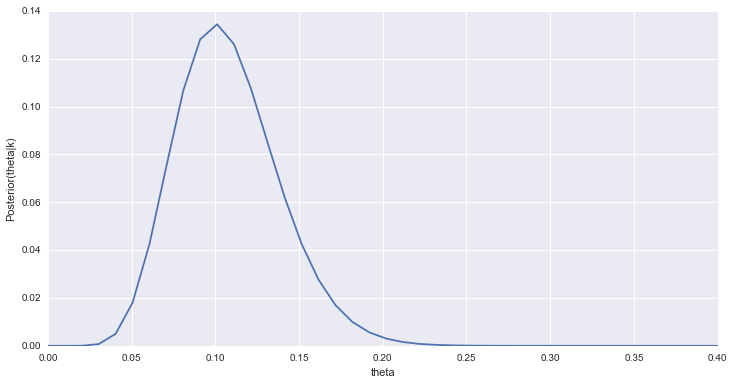

In [14]:
#observations
N = 100
k = 10

#inference
tmpP = np.linspace(0,1,100)
like_theta = binom.pmf(k,n=N,p=tmpP)
prior_theta = 1 # simply constant
posterior_theta = like_theta * prior_theta/ np.sum(like_theta * prior_theta)

plot(tmpP,posterior_theta)
xlabel('theta'), ylabel('Posterior(theta|k)'), xlim([0,0.4])

## Instead
- also works the other way around:
- estimate the posterior of $N$ for observed $f$ and $k$:
<p>
$$P(N|k,f)=\frac{L(k,f|N) \cdot \pi(N)}{\int L(k,f|N) \cdot \pi(N)\;dN}$$ 

(<matplotlib.text.Text at 0x7f99b5dce810>,
 (0, 0.1))

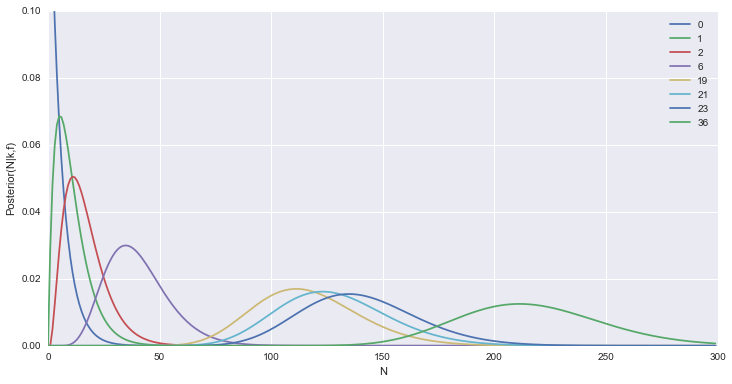

In [15]:
n = np.arange(300)
data = unique(colonies_per_spleen["exp1"]) #just considering the first experiment
posteriorArray = np.zeros((len(data), len(n)))
for i,d in enumerate(data):
    likelihood_n = binom.pmf(d, n, fraction)
    prior_n = 1 #constant
    posterior_n = likelihood_n * prior_n / np.sum(likelihood_n*prior_n)
    posteriorArray[i,:] = posterior_n

plot(n,posteriorArray.T)
xlabel('N'), ylabel('Posterior(N|k,f)'), legend(data),  ylim([0, 0.1])

###Conclusion: careful with uncertainties, ignorance makes you overconfident
How to include uncertainty in $f = 0.17 \pm 0.02$ ?

# A first look at the data
- lets ignore those uncertainties now for simplicity and use the MLEs (counts/0.17)
- uncertainty propagation in the end (maybe)

## Histograms

(<matplotlib.text.Text at 0x7f99b5cab850>,
 <matplotlib.text.Text at 0x7f99b5d30450>)

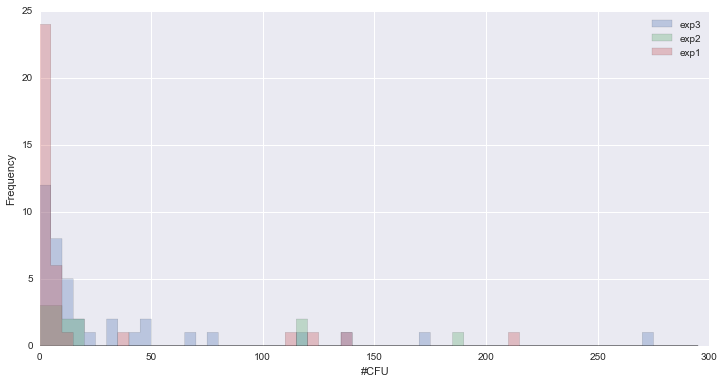

In [16]:
#normal hists
binning = np.arange(0,300,step=5)
plt.figure()
for exp,data in trueCFUs.iteritems():
    plt.hist(data, bins=binning, histtype="stepfilled", alpha=.3)
plt.legend(trueCFUs.keys())
xlabel('#CFU'), ylabel('Frequency')

## Cumulative distribution function
Definition: $P(X\le x) = \sum_{i=-\infty}^x P(X=x)$

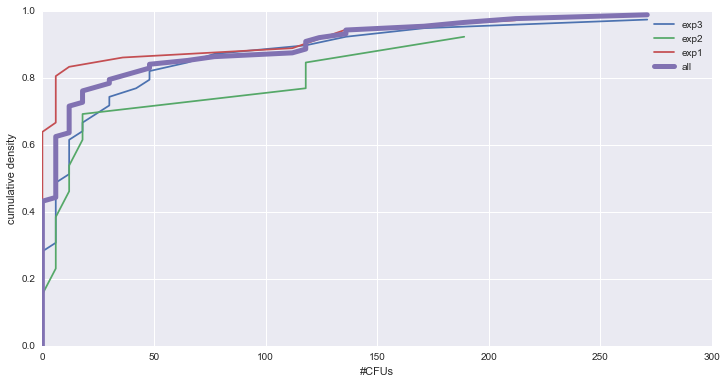

In [17]:
def ecdf(x):
    """ calculate the empirical distribution function of data x """
    sortedX=np.sort( x )
    yvals=np.arange(len(sortedX))/float(len(sortedX))
    return sortedX, yvals


# plot the CDF for each experiment individually
for exp,data in trueCFUs.iteritems():
    x,y = ecdf(data)
    plt.plot(x,y)
xlabel('#CFUs'), ylabel('cumulative density')

#put all three together
trueCFUs_all = np.concatenate(trueCFUs.values())
x,y = ecdf(trueCFUs_all)
plt.plot(x,y, linewidth=5)

leg= trueCFUs.keys()
leg.append('all')
plt.legend(leg)

## Figure 4 from the paper

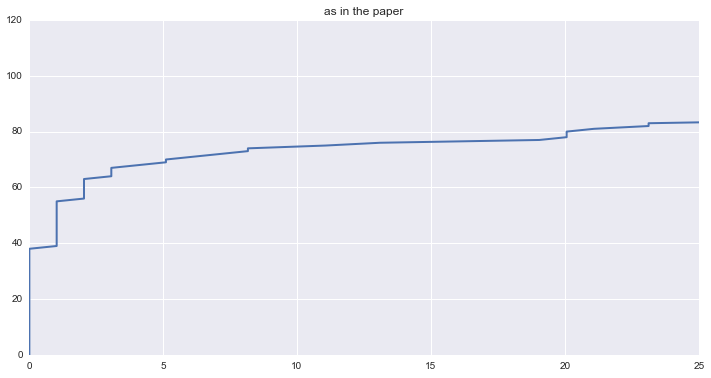

In [18]:
plt.figure() # the figure as presented in the paper (scaled back to colonies)
plt.plot(x*0.17,y*len(trueCFUs_all), linewidth=2)
xlim([0,25])
ylim([0,120])
title('as in the paper')

![cdfPaper](figures/Fig4CDF.png)

## Comparison to a Possion distribution
- why would you compare to a Poisson?
- for Possion, $E[X] = Var[X]$
- or equivalent: **Fano-factor** $F = \frac{Var[X]}{E[X]} = 1$

In [19]:
mu = np.mean(trueCFUs_all)
sigma= np.std(trueCFUs_all)
print "Mean: %f Fano factor %f" % (mu,sigma**2/mu)

Mean: 26.988636 Fano factor 104.922522


(<matplotlib.text.Text at 0x7f99b60d1a10>,
 <matplotlib.legend.Legend at 0x7f99b5e38f50>)

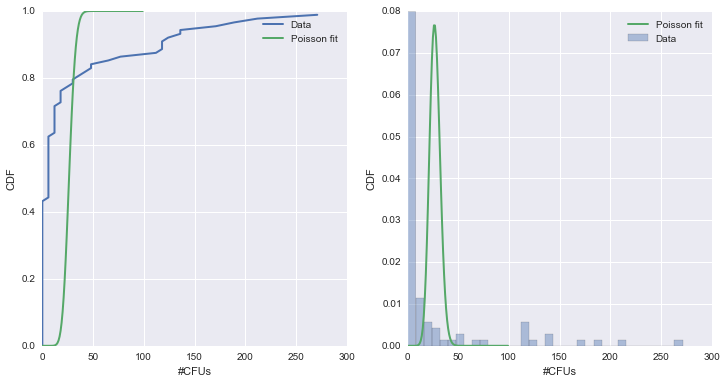

In [20]:
# put the poisson distribution as a comparision which has the same mean as the data
x_ECDF,y_ECDF = ecdf(trueCFUs_all)

x = np.arange(0,100)
y =stats.poisson.cdf(x,mu)

plt.subplot(1,2,1)
plt.plot(x_ECDF, y_ECDF, linewidth=2)
plt.plot(x,y, linewidth=2)
plt.xlim([0,300])
plt.xlabel('#CFUs'), plt.ylabel('CDF'), plt.legend(['Data','Poisson fit'])

# DO THE PDF as well, much easier to see
#plt.figure()
plt.subplot(1,2,2)
sns.distplot(trueCFUs_all,norm_hist=True, kde=False)
plt.plot(x,stats.poisson.pmf(x,mu), linewidth=2)
plt.xlabel('#CFUs'), plt.ylabel('CDF'), plt.legend(['Poisson fit', 'Data'])

## Comparison to a $\Gamma$-distribution
- two parameters
    - shape $k$, scale $\theta$
    - $E[X] = k \cdot\theta$
    - $Var[X] = k \cdot \theta^2$
- conveniently, scipy.stats does a MLE fit of $\Gamma$-distributions out of the box    

(<matplotlib.text.Text at 0x7f99b54bbed0>,
 <matplotlib.legend.Legend at 0x7f99b543ca90>)

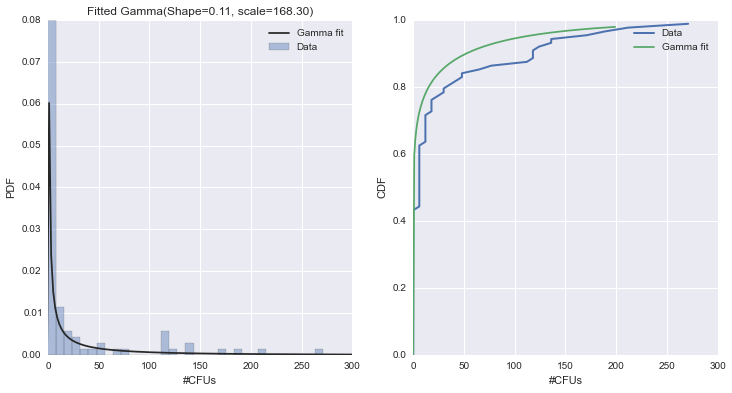

In [21]:
plt.subplot(1,2,1)
sns.distplot(trueCFUs_all, fit =stats.gamma, kde=False)
xlim([0, 300])
plt.xlabel('#CFUs'), plt.ylabel('PDF'), plt.legend(['Gamma fit', 'Data'])

# lets look at the CDF as well
shape,loc,scale = stats.gamma.fit(trueCFUs_all)
plt.title('Fitted Gamma(Shape=%.2f, scale=%.2f)' % (shape,scale))

x_Gamma = np.arange(0,200)
y_Gamma = stats.gamma(shape,scale=scale).cdf(x_Gamma)

plt.subplot(1,2,2)
plt.plot(x_ECDF, y_ECDF, linewidth=2)
plt.plot(x_Gamma, y_Gamma)
plt.xlabel('#CFUs'), plt.ylabel('CDF'), plt.legend(['Data', 'Gamma fit'])

# Uncertainty revisited

## Until now
- Sampling error was ignored entirely
- MLE estimates of #CFU 
<img src="figures/spleenScetch.png" alt="Image not present" style="width: 600px;"/>
<img src="figures/uncertaintyRevisit.png" alt="Image not present" style="width: 600px;"/>

## Including sampling uncertainty
- fitting a $\Gamma$-distribution to the observations, accounting for these errors
- Bayesian inference
     - graphical model (network of random variables)   

<img src="figures/GModel2.png" alt="Image not present" style="width: 800px;"/>     
  - describes the joint distribution $P(\alpha,\beta,f,nCFU,nColonies)$
  - inference via MCMC
      - estimate  $P(\alpha,\beta,f |nColonies)$
      - [Pymc3](https://github.com/pymc-devs/pymc3) package

### The posterior $P(\alpha,\beta, f | Data)$
<img src="figures/uncertainty_MCMC.png" alt="Image not present" style="width: 800px;"/>    
<img src="figures/uncertainty_2dPosterior.png" alt="Image not present" style="width: 800px;"/>

### Samples from the posterior
<img src="figures/uncertainty_posteriorPredictive.png" alt="Image not present" style="width: 600px;"/>

## Conclusion
- Poisson model **doesn't fit at all**
- $\Gamma$-distribution looks better, but kind of unmotivated

![cdfPaper](figures/Fig4CDF.png)

# The stochastic model
How to explain the data otherwise?
- two cell states:
    - **stem cells**
    - **differentiated cells**
* * *
<img src="figures/TillFig67.png" alt="Drawing" style="width: 900px;"/>

<img src="figures/TillFig67.png" alt="Drawing" style="width: 900px;"/>

- probabilistic model: 
    - decision to divide or differentiated is stochastic
    - unknown probability **p0** to differentiate (p2= 1-p0)
    
- solvable analytically only for exponential lifetimes

- instead: **Monte Carlo** simulation

## Fun fact: Hardware in 1960
- **IBM 7090**
- 500.000 \$ 
- Gemini/Mercury space flights
- 100 kFLOPS/s  
    - modern mobile phone: 100 MFLOPS/s
    - this laptop: ~ GFLOPS/s
<img src="figures/IBM7090.jpg" alt="Drawing" style="width: 600px;"/>
    


In [22]:
def simulateTree(p0, nGens):
    """  simulates a single tree from the Till/McCulloch model
    
    inputs:
        - p0: probability that a single cell undergoes terminal 
              differentiation (i.e. no more division)
        - nGens: number of generations to simulate
    
    returns: 
        - a list (one element per generation) of single cells 
          present at that generation.
        - a single element is just an array of cells present at that time 
          (zeros for stem cells, 1s for differentiated cells).
    """
    
    # cell state is either 0 (stem cell) or 1 (differentiated),
    # which is the only thing we keep track of here
    theGenerations = list()
    theGenerations.append(np.array(0))
    
    for g in range(nGens):
        lastGen = theGenerations[-1]
        
        # for each of the last generation, roll a dice whether it terminally diffs
        newState = roll_the_dice(lastGen, p0)
        
        #all the zeros divide, the 1's just stay
        n0 = sum(newState==0)
        n1 = sum(newState==1)
        nextGen = np.concatenate([np.repeat(0, 2*n0), np.repeat(1,n1)])

        theGenerations.append(nextGen)

    return theGenerations


def roll_the_dice(cellstate_array, p0):
    """
    decide if a cell goes from 0->1 (wit probability p0)
    does that for an entire vector of zeros and ones in paralell
    """
    # helper function so that we can index into it via generation
    # makes sure that as soon as cell_state==1 it wont change anymore
    tmpP = np.array([p0, 1])     
    p = tmpP[cellstate_array]
    r = np.random.rand(cellstate_array.size)
    newGeneration = r<p
    
    return newGeneration.astype(int)

## Create some trees/colonies, calculate  number of CFUs within

In [23]:
def pretty_print_tree(tree):
    for gen in tree:
        print gen

In [24]:
p0 = 0.4
nGens = 5
aTree = simulateTree(p0,nGens)
bTree = simulateTree(p0,nGens)
print 'First tree'
pretty_print_tree(aTree)

print 'Second tree'
pretty_print_tree(bTree)

First tree
0
[1]
[1]
[1]
[1]
[1]
Second tree
0
[0 0]
[0 0 1]
[0 0 1 1]
[0 0 1 1 1]
[0 0 0 0 1 1 1]


In [25]:
#CFUs per generation
print '\n#CFUs, first tree'
print map(lambda x: sum(x==0), aTree)

print '\n#CFUs, second tree'
print map(lambda x: sum(x==0), bTree)


#CFUs, first tree
[1, 0, 0, 0, 0, 0]

#CFUs, second tree
[1, 2, 2, 2, 2, 4]


## Distribution of #CFUs over time

In [26]:
nTrees = 1000
nGens = 20
p0 = 0.4

# assemble a matrix of tree vs #CFUs(t)  (one row, one tree; one col one timepoint)
cfus_over_time = np.zeros((nTrees, nGens+1))
for i in range(nTrees):
    tree = simulateTree(p0, nGens)
    nCFU = map(lambda x: np.sum(x==0), tree)
    cfus_over_time[i,:] = nCFU   

print cfus_over_time[0:5,:].astype(int)

[[ 1  2  2  4  6  8 12 12 10 12 14 14 20 16 24 32 40 40 42 44 48]
 [ 1  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  4  4  6  8  8  8  6  4  4  6  4  6  8 12 16 18 24 24 26]
 [ 1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  4  8  8 14 18 20 26 30 32 28 30 38 34 40 52 58 68 88 90]]


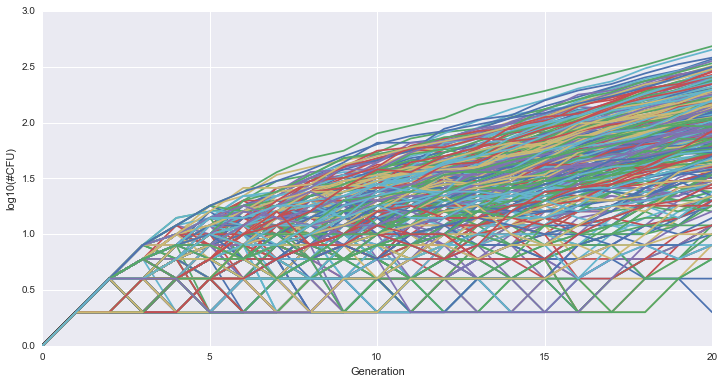

In [27]:
import seaborn as sns

plt.plot(log10(cfus_over_time.T))
plt.xlabel('Generation')
plt.ylabel("log10(#CFU)")

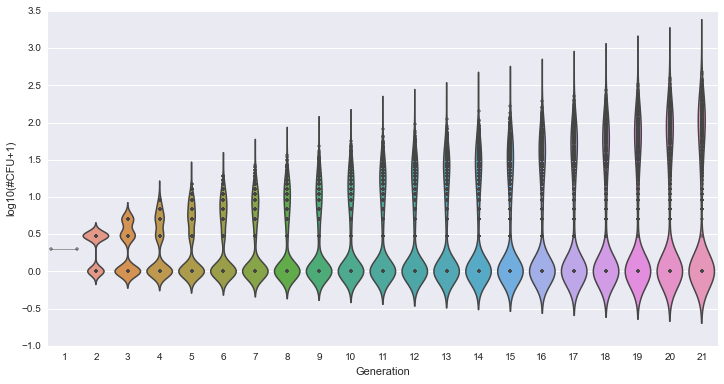

In [28]:
# violin plot
plt.figure()
sns.violinplot((log10(cfus_over_time+1)), inner='points')
plt.xlabel('Generation')
plt.ylabel("log10(#CFU+1)")

###Last generation

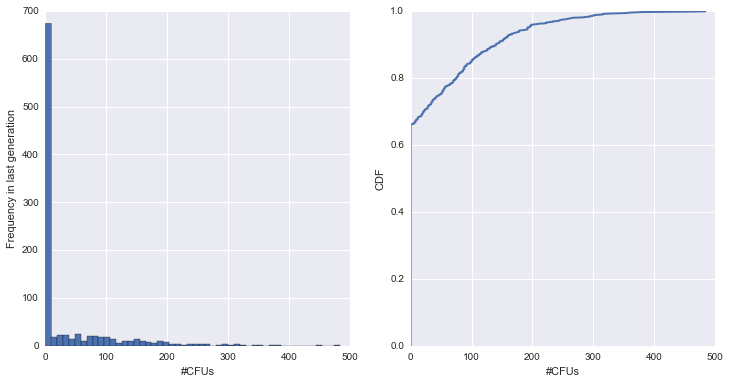

In [29]:
lastGen_nCFUs = cfus_over_time[:,-1]

plt.subplot(1,2,1)
plt.hist(lastGen_nCFUs, bins=50)
xlabel('#CFUs')
ylabel('Frequency in last generation')

# CDF
plt.subplot(1,2,2)
x_ECDF_lastGen,y_ECDF_lastGen = ecdf(lastGen_nCFUs)
plt.plot(x_ECDF_lastGen, y_ECDF_lastGen, linewidth=2)
xlabel('#CFUs')
ylabel('CDF')

<img src="figures/ExperimentData.png" alt="Drawing" style="width: 600px;"/>

##$\Gamma$-distribution fit

Shape: 0.260,  Location: -0.000,  Scale: 60.575


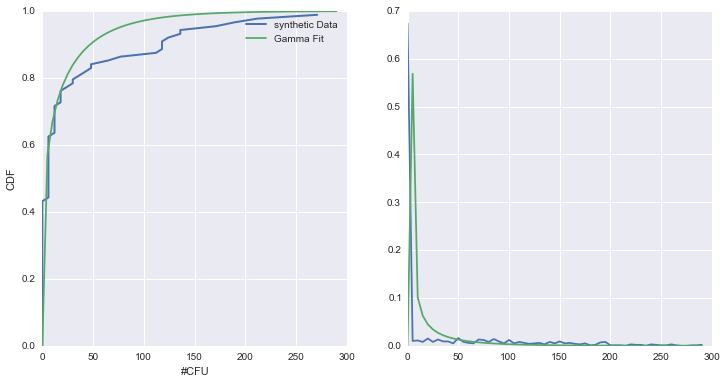

In [30]:
shape, loc, scale = stats.gamma.fit(lastGen_nCFUs)
fittedGamma = stats.gamma(a=shape, loc=loc, scale=scale)
print "Shape: %.3f,  Location: %.3f,  Scale: %.3f" %(shape, loc, scale)

# histogram of the simulated data
n,bins = np.histogram(lastGen_nCFUs, bins=arange(0, 300, step=5))

# pdf, cdf
fittedPDF, fittedCDF  =  fittedGamma.pdf(bins[:-1]), fittedGamma.cdf(bins[:-1])

plt.subplot(1,2,1)
plt.plot(x_ECDF, y_ECDF, linewidth=2)
plt.plot(bins[:-1], fittedCDF)
xlabel('#CFU'), ylabel('CDF'), legend(['synthetic Data','Gamma Fit'])

## the PDF derived from the cdf
plt.subplot(1,2,2)
plt.plot(bins[:-1],n/n.sum())
plt.plot(bins[:-1], diff(np.insert(fittedCDF, 0, 0)))

In [31]:
#estimates, based on matching means an vars
gamma_mean, gamma_var = fittedGamma.stats(moments='mv')
sample_mean, sample_var = np.mean(lastGen_nCFUs), np.var(lastGen_nCFUs)


myShape = sample_mean**2/sample_var
myScale = sample_var/sample_mean
print myShape,myScale
#fittedGamma = stats.gamma(a=myShape, loc=0, scale=myScale)


print "Sample Mean: %.2f  Gamma Mean: %.2f" % (sample_mean,gamma_mean)
print "Sample Var: %.2f  Gamma Var: %.2f" % (sample_var,gamma_var)


0.26751498967 137.69695689
Sample Mean: 36.84  Gamma Mean: 15.73
Sample Var: 5072.21  Gamma Var: 953.08


#Trying to reproduce Figure 8
Monte Carlo simulation vs $\Gamma$-distribution

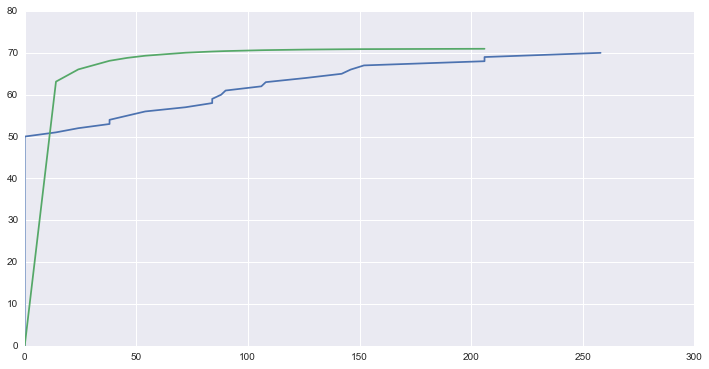

In [32]:
nGens = 20
p0 = 0.4
nTrees_fig8 = 71
fig8_cfu_20 = np.zeros((nTrees_fig8))
for i in range(nTrees_fig8):
    tree = simulateTree(p0, nGens)
    nCFU = map(lambda x: np.sum(x==0), tree)
    fig8_cfu_20[i] = nCFU[-1]
    
xTmp, yTmp = ecdf(fig8_cfu_20)
plot(xTmp, yTmp*nTrees_fig8)

#fit by gamma
shape, loc, scale = stats.gamma.fit(fig8_cfu_20)
fittedGamma_synthData = stats.gamma(a=shape, loc=loc, scale=scale)
fittedCDF  =  fittedGamma_synthData.cdf(xTmp[:-1])
plot(xTmp[:-1], fittedCDF*nTrees_fig8)


#Exercise: Fitting the Birth Death model to the data

- no likelihood available (at least not so simple -> branching processes)
- simulate data, compare to observations
    - comparing the means/variance
    - histogram distance

In [33]:
"Simulate a bunch of trees and get the #CFUs over time"
def sim_cfu_over_time(p0, nTrees, nGens):
    cfus_over_time = np.zeros((nTrees, nGens+1))
    for i in range(nTrees):
        tree = simulateTree(p0, nGens)
        nCFU = map(lambda x: np.sum(x==0), tree)
        cfus_over_time[i,:] = nCFU
    return cfus_over_time

"calculate a KS test between observed and simulated dists"
def distance_function(obs, sim):
    K,pval = stats.ks_2samp(obs,sim)
    return K, pval
    #return np.abs(np.mean(obs)- np.mean(sim))

p0_grid = np.linspace(0, 1, 50)
distances, pvals = np.zeros(p0_grid.shape), np.zeros(p0_grid.shape)
observedData = trueCFUs_all # experimental data after 10 days/20divisions

for i, p0 in enumerate(p0_grid):
    simData = sim_cfu_over_time(p0, nTrees = 100, nGens= 20)
    simData_lastGen = simData[:,-1]
    distances[i], pvals[i] = distance_function(obs= observedData, sim=simData_lastGen)

In [34]:
def plot_fitted_stoch_model(p0_array, K_array, pval_array, observedData):
    bestP0 = p0_array[argmin(K_array)]
    plt.subplot(2,2,1)
    plt.plot(p0_array, K_array)
    plt.vlines(bestP0,0,1)
    xlabel('p0'), ylabel('KS distance')

    plt.subplot(2,2,2)
    plt.plot(p0_array, log10(pvals))
    xlabel('p0'), ylabel('KS pval')
    bestpval = pval_array[argmin(K_array)]
    title(bestpval)

    plt.subplot(2,2,3)
    simData = sim_cfu_over_time(p0=0.4, nTrees = 100, nGens= 20)

    x,y =ecdf(observedData)
    plt.plot(x, y)

    x,y =ecdf(simData[:,-1])
    plt.plot(x, y)
    xlabel('#CFU'), ylabel('CDF')
    legend(['observed','simulated'])

    binning = np.arange(0,300,step=5)
    plt.subplot(2,2,4)
    plt.hist(observedData, bins=binning, histtype="stepfilled", alpha=.5)
    plt.hist(simData[:,-1], bins=binning, histtype="stepfilled", alpha=.5)
    xlabel('#CFU'), ylabel('PDF')

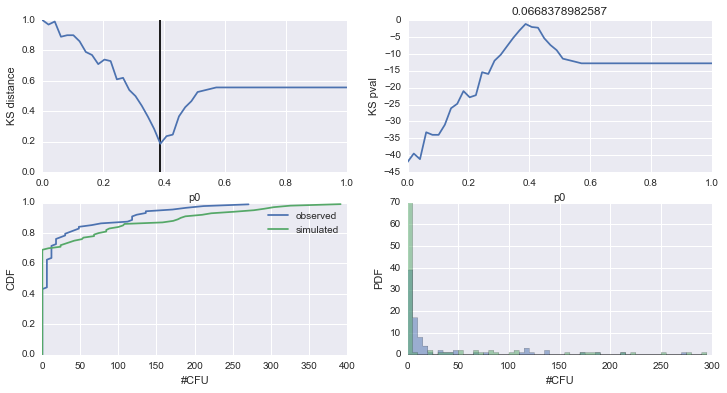

In [35]:
plot_fitted_stoch_model(p0_grid, distances, pvals, observedData)

#Discussion

- very heterogeneous data explained (kind of) by a simple stochastic model

##How is that compatible with ordered hematopoiesis?
- e.g. you could run out of stem cells due to bad luck
- regulation handled on a statistical level
- individual cells are random but a pattern on population level emerges

##Current area of research
- regulation via cell-cell communication
- randomness due to gene expression noise
<img src="figures/Clevers1.png" alt="Image not present" style="width: 800px;"/>
Simons, B. D. & Clevers, H. Strategies for homeostatic stem cell self-renewal in adult tissues. Cell 145, 851–62 (2011).

<center><h1>THE END</h1></center>
* * *
<center><h3>Next week:</h3></center>
<center><h4>Bifurcation dynamics in lineage-commitment in bipotent progenitor cells.</h4></center>

- ODEs
- Bifurcation analysis
- microArrays